# Lab Weeks 8

Author: Dr. Amirhassan MONAJEMI. Modified by Weida Liang

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# from utils_2023:
# 
# this function generates a lowpass Gaussian filter
# image and filter size is MxN , STD of the Gaussian is D0 which is also the cut_off
# point of the filter
# 
def GaussLowPass(M, N, D0):
    filter = np.zeros((M, N))
    # normalized cut_off frequency is mapped to real index
    D0 = D0 * min(M,N) / 2
    for i in range(M):
        for j in range(N):
            d = ( (i-M/2)**2 + (j-N/2)**2 )**0.5
            filter[i,j]= np.exp(-((d/2/D0)**2) )
            
    return filter

### part 1:  GLCM-based Texture Analysis
1. For images below, where GL=256 for all, 
- hor_texture.jpg 
- high_spat_freq.bmp
- IMG_8636q.jpg 
2. Convert them the GL if it's necessary 
3. Apply a Gaussian lowpass filter on IMG_8636q.jpg next
4. Compute 4 GLCM matrices for distance=d=[1,5] , theta= [0,90] for each texture
5. Compute F1 and F2 for each GLCM matrix. 
6. This way, you will have a 2-feature feature vector for each GLCM matrix, 
- or a 8-feature feature vector to represent your texture
7. Compare GLCMs' [F1, F2] feature vectors with each other and discuss the results


In [29]:

def am_glcm_faster( img , GL , d , t):
    ccmm = np.zeros([GL, GL])
    if t==0:
        im_target = img[:,d:]
        im_value = img[:,:-d]
    # Use the above example and write your code for t = 45,90,135
    elif t==45:
        im_target = img[d:, d:]
        im_value = img[:-d, :-d]
    elif t==90:
        im_target = img[d:, :]
        im_value = img[:-d, :]
    elif t==135:
        im_target = img[:-d, :-d]
        im_value = img[d:, d:]
    else:
        raise NotImplementedError('t options: 0, 45, 90, 135 only')
    assert im_target.shape==im_value.shape
    ref_gls = np.unique(im_value)
    # print(ref_gls)
    for ref in ref_gls:
        target_values = im_target[im_value == ref]
        target_gls = np.unique(target_values)
        # print(target_gls)
        for target in target_gls:
            # print(target, target_values,(target_values==target).sum())
            ccmm[ref, target] = (target_values==target).sum()
    
    return ccmm

### you may use function below to compute F1 and F2 （maximum and energy) , for your texture

In [30]:
def glcm_feat( g11 ):
    mxx = np.max(g11)
    enrg = np.sum(np.multiply(g11,g11))
    return  mxx , enrg

# High energy value = uniformly changing texture
# Low energy value = similar texture

(1018.0, 706702976.0)


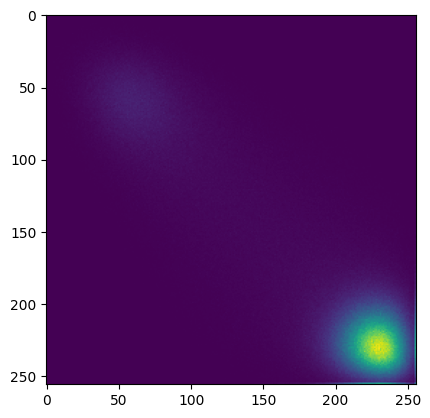

In [34]:
# Imput Image
input_image = cv2.imread('./CS4243_2023_images_small/hor_texture.jpg', cv2.IMREAD_GRAYSCALE)
# Your code Here
M, N = input_image.shape
# Wrong code used here, cannot use GaussLowPass() because it is a filter that is meant to be used only in frequency(Fourier) domain.
# Use the GaussBlur() from openCV2 instead as that is the GaussKernel filter that is meant to be used in spatial domain.
f = GaussLowPass(M, N, 0.8)
hor_texture_filtered = cv2.filter2D(input_image, -1, f)
GL = 256
d = [1, 5]
t = [0, 90]
# Use am_glcm_faster function to get results
ccmm = am_glcm_faster( input_image , GL , d[0] , t[0])
print( glcm_feat( ccmm ))
plt.imshow(ccmm)

### part 2: Laws Filters: A bank of small size filters to extract texture features
1. Use instructions below to creat a 9-filter 3x3 Laws filter bank 
2. Use images below, apply all Laws filters on them, compute the filter response
3. Filter responses will configure a 9-featured feature vector
- Images: 
- IMG_0054_1024bw.bmp
- 20230515_110806.jpg 
- djzam_nat_defect_002_2g_8.bmp 
- 20230324_105524gl.jpg 
4. Discuss the results

### L3 = (1,2,1) - Level detection, E3 = (-1,0,1)- Edge detection, and S3 = (-1,2,-1)- Spot detection.

In [8]:
L = np.array([1,2,1]) / 4
# or: L = np.array([1,2,1])
E = np.array([-1,0,1])
S = np.array([-1,2,-1])
llist = [L, E, S]

laws = []
for xs in llist:
    for ys in llist:
        xs= np.reshape(xs,(3,1))
        ys = np.reshape(ys,(1,3))
        L3L3 = np.matmul(xs,ys)  
        print(L3L3)
        laws.append(L3L3)

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
[[-0.25  0.    0.25]
 [-0.5   0.    0.5 ]
 [-0.25  0.    0.25]]
[[-0.25  0.5  -0.25]
 [-0.5   1.   -0.5 ]
 [-0.25  0.5  -0.25]]
[[-0.25 -0.5  -0.25]
 [ 0.    0.    0.  ]
 [ 0.25  0.5   0.25]]
[[ 1  0 -1]
 [ 0  0  0]
 [-1  0  1]]
[[ 1 -2  1]
 [ 0  0  0]
 [-1  2 -1]]
[[-0.25 -0.5  -0.25]
 [ 0.5   1.    0.5 ]
 [-0.25 -0.5  -0.25]]
[[ 1  0 -1]
 [-2  0  2]
 [ 1  0 -1]]
[[ 1 -2  1]
 [-2  4 -2]
 [ 1 -2  1]]


In [9]:
# function to compute the power of an image, either RGb or graylevel
def am_power(a):
    dim1 = a.shape
    if len(dim1)==2:
        sz = dim1[0] * dim1[1] 
    else:
        sz = dim1[0] * dim1[1] * dim1[2]
    pa = np.sum( np.double(a)**2 )
    pa = pa / sz
    return pa 

#### now in laws we have got a list of 9 filters, 3x3 each

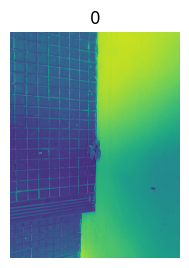

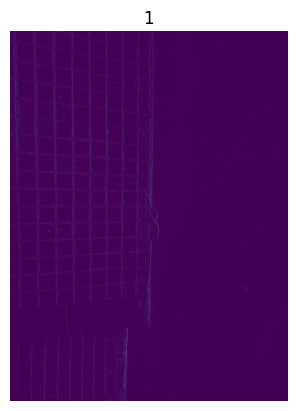

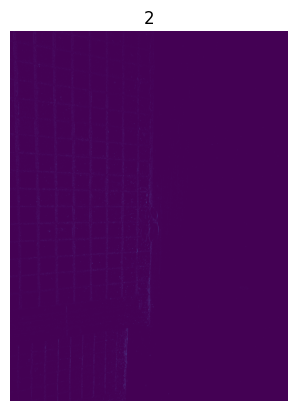

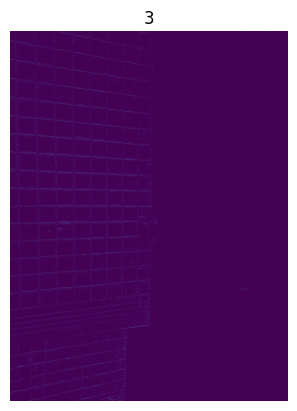

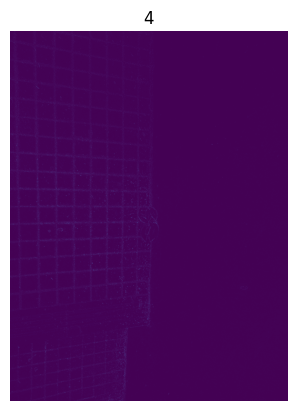

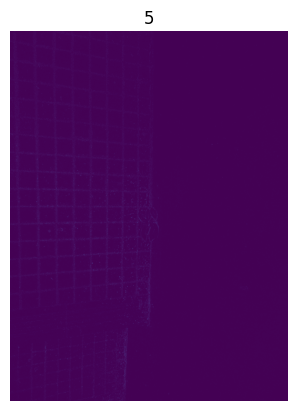

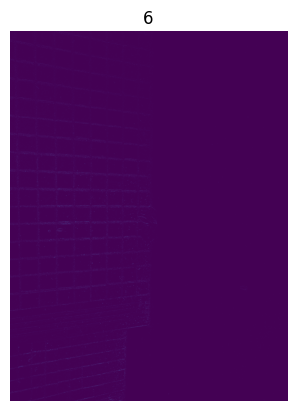

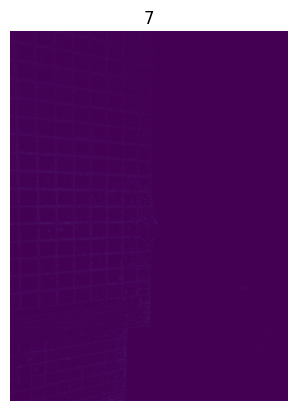

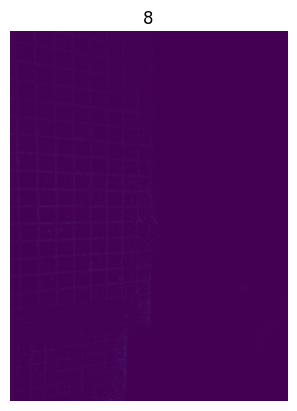

In [27]:
# Images: 
# - IMG_0054_1024bw.bmp
# - 20230515_110806.jpg 
# - djzam_nat_defect_002_2g_8.bmp 
# - 20230324_105524gl.jpg 
# create figure
fig = plt.figure(figsize=(10,10))
image = cv2.imread('./CS4243_2023_images_small/20230324_105524gl.jpg', cv2.IMREAD_GRAYSCALE)
image_power=[]
feature=[]
# setting values to rows and column variables
rows = 3
columns = 3

for i in range(9):
    f1 = cv2.filter2D(src=image, ddepth=-1, kernel= laws[i])
    fig.add_subplot(rows, columns, i+1) 
    # showing image
    plt.imshow(f1)
    plt.axis('off')
    plt.title(i)
    plt.show()
    image_power.append(am_power(f1))
    feature.append(f1)

In [13]:
#calculate powers
print('original image power= ' , am_power(image) )
for i in range(9):
    print('power of ', i ,'th filter response=', image_power[i] )

original image power=  15998.823437690735
power of  0 th filter response= 14785.399900436401
power of  1 th filter response= 1716.4544563293457
power of  2 th filter response= 1593.0382480621338
power of  3 th filter response= 1241.4806594848633
power of  4 th filter response= 2941.0554037094116
power of  5 th filter response= 3603.031876564026
power of  6 th filter response= 760.3650732040405
power of  7 th filter response= 2342.868248939514
power of  8 th filter response= 3807.8108167648315


### part 3: Gabor Filters: MSMD Approaches
1. Use images below and Gabor function from cv2, 
2. Try different parameters of the Gabor filter and see the results
- Images: 
- IMG_0054_1024bw.bmp
- 20230515_110806.jpg 
- djzam_nat_defect_002_2g_8.bmp 
- 20230324_105524gl.jpg 
4. Discuss the results

In [21]:
# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
# 2d Gabor filter for image processing, is a 2d sine wave modulated by a Gaussian envelop
# 
# -- ksize - size of gabor filter (n, n), usually it is small, e.g. 7x7 to 30x30, size of the filter
# matrix
# -- sigma - standard deviation of the gaussian function, filter bandwidth, bandwidth of that Gaussian envelop
# -- theta - orientation of the normal to the parallel stripes, we can rotate the filter, 
# direction of the 2d sine wave
# -- lambda - wavelength of the sinusoidal factor, wavelength = 1/ frequency of the filter sine wave
# -- gamma - spatial aspect ratio, 
# -- psi - phase offset, usually 0 , phase of that sine wave
# -- ktype - type and range of values that each pixel in the gabor kernel can hold,
#either 32 bit or 64 bit, float 

In [40]:
# Images: 
# - IMG_0054_1024bw.bmp
# - 20230515_110806.jpg 
# - djzam_nat_defect_002_2g_8.bmp 
# - 20230324_105524gl.jpg 
# building the filter kernel, theta=90
g_kernel90 = cv2.getGaborKernel((21, 21), 8.0, np.pi/2, 10.0, 0.5, 0, ktype=cv2.CV_32F)
# image in gray level and convolution for 2d filtering
img = cv2.imread('./CS4243_2023_images_small/IMG_0054_1024.bmp',0)
 
filtered_img90 = cv2.filter2D(img, cv2.CV_8UC3, g_kernel90)

# showing the input and filtered images
cv2.imshow('image', img)
cv2.imshow('filtered image, theta=90', filtered_img90)

# making the filter larger just to show that
h, w = g_kernel90.shape[:2]
g_kernel2 = cv2.resize(g_kernel90, (10*w, 10*h), interpolation=cv2.INTER_CUBIC)
cv2.imshow('gabor kernel, theta=90 (resized)', g_kernel2)

In [41]:
# building the filter kernel,theta=0, similar to code above
# Your code here
g_kernel0 = cv2.getGaborKernel((21, 21), 8.0, 0, 10.0, 0.5, 0, ktype=cv2.CV_32F)

img2 = cv2.imread('./CS4243_2023_images_small/IMG_0054_1024.bmp',0)

filtered_img0 = cv2.filter2D(img2, cv2.CV_8UC3, g_kernel0)
# showing the input and filtered images
cv2.imshow('image', img2)
cv2.imshow('filtered image, theta=90', filtered_img0)

# making the filter larger just to show that
h1, w1 = g_kernel0.shape[:2]
g_kernel4 = cv2.resize(g_kernel0, (10*w1, 10*h1), interpolation=cv2.INTER_CUBIC)
cv2.imshow('gabor kernel, theta=90 (resized)', g_kernel4)


Text(0.5, 1.0, 'gabor kernel 2, theta=0 (resized)')

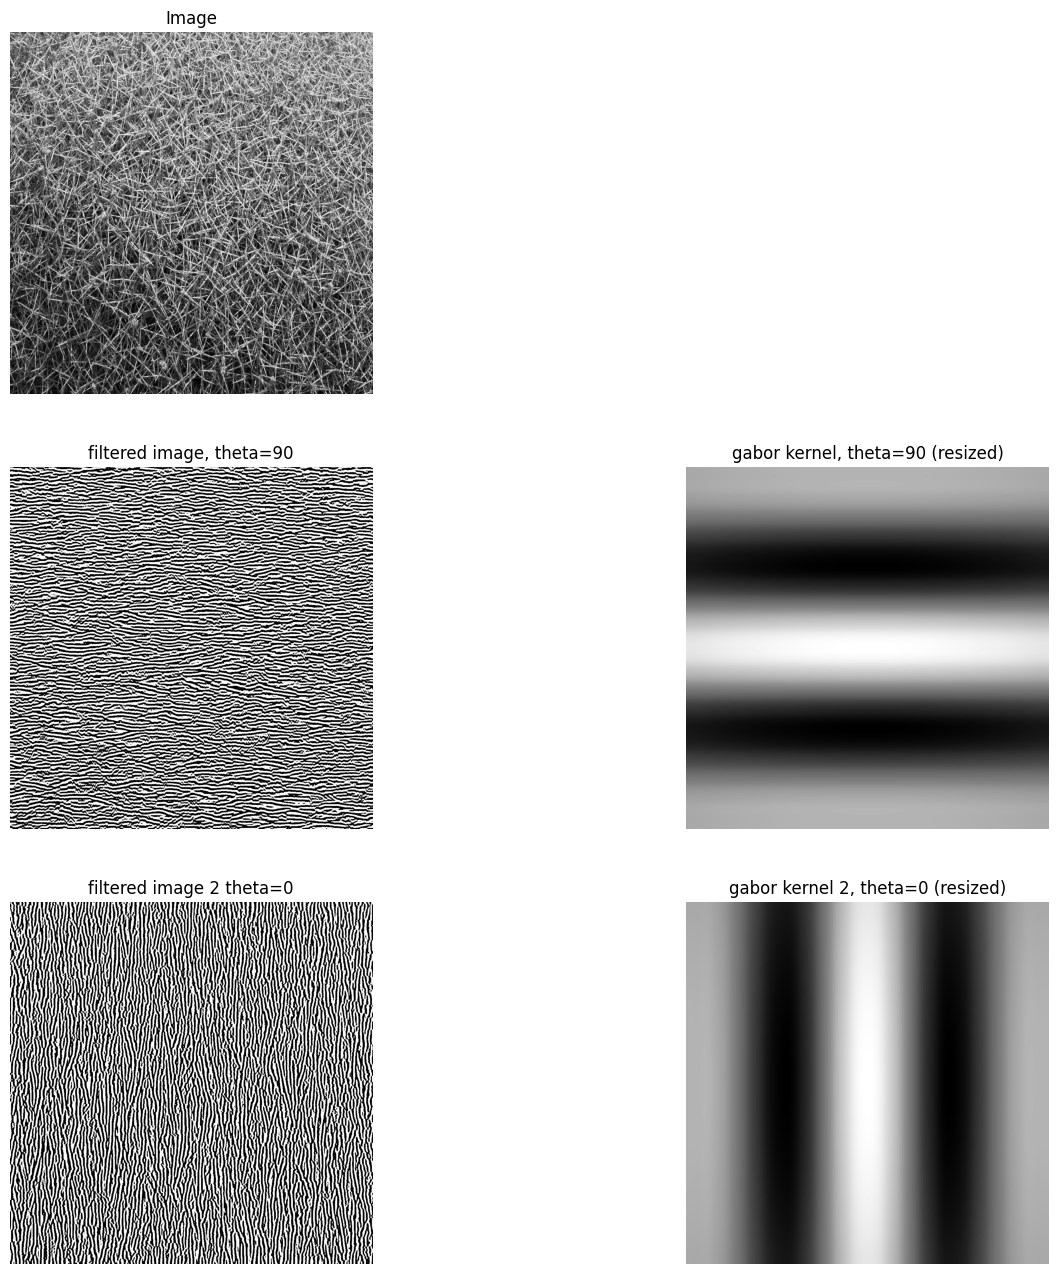

: 

In [42]:
# create figure
fig = plt.figure(figsize=(16,16))

# setting values to rows and column variables
rows =3
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(img , cmap='gray')
plt.axis('off')
plt.title("Image")

fig.add_subplot(rows, columns, 3)
plt.imshow( filtered_img90 , cmap='gray')
plt.axis('off')
plt.title("filtered image, theta=90")

fig.add_subplot(rows, columns, 4)
plt.imshow(g_kernel2, cmap='gray')
plt.axis('off')
plt.title('gabor kernel, theta=90 (resized)')

fig.add_subplot(rows, columns, 5)
plt.imshow(filtered_img0, cmap='gray')
plt.axis('off')
plt.title('filtered image 2 theta=0')

fig.add_subplot(rows, columns, 6)
plt.imshow(g_kernel4, cmap='gray')
plt.axis('off')
plt.title('gabor kernel 2, theta=0 (resized)')